In [1]:
import numpy as np
import pandas as pd
import functions.multi_occupation_network as multi_occupation_network
import functions.nominal_rigidity_network as nominal_rigidity_network
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from  functions.network_figures import bar_plot
import scipy.optimize as opt

In [2]:
A_spec = 1
data_dir = '../data/clean/'
dfTau    = pd.read_csv(data_dir + 'tau_2021_occu.csv').sort_values(by=['variable'])
dfepsN   = pd.read_csv(data_dir + 'epsN_2021.csv', index_col=0).sort_index(axis=1)
dfcurlyL = pd.read_csv(data_dir + 'curlyL_2021.csv', index_col=0).sort_index()
dfA      = pd.read_csv(data_dir + f'A{A_spec}.csv')
sectors  = dfA['short_names']
dfDemand = pd.read_csv(data_dir + 'demand_tab.csv')
dfLshare = pd.read_csv(data_dir + 'labor_tab.csv')
dfLabor_market_yearly= pd.read_csv(data_dir + 'uvh_annual_updated_occu.csv')
dfLabor_market_yearly = dfLabor_market_yearly.sort_values(by=['Year', 'variable'])
dfLabor_market_yearly = dfLabor_market_yearly.dropna(axis=0)
dfLabor_market_yearly = dfLabor_market_yearly[dfLabor_market_yearly['Year'] == 2021]
dfMatching_params = pd.read_csv(data_dir + 'matching_param_estimates_occu.csv')
shares = pd.read_csv(data_dir + 'energy_capital_shares.csv')
sector_names = list(dfA['short_names']) + ['Agg Y']
occupation_names = list(dfcurlyL.index)

In [3]:
# reformatting parameters
Omega = np.array(dfA.iloc[:, 1:], dtype='float64')
rescaler = np.matrix(1 - shares['Capital share'] - shares['Energy share'])
J = Omega.shape[0]
Omega = np.multiply(Omega, (np.repeat(rescaler, J).reshape(J, J)))
Psi = np.linalg.inv(np.eye(Omega.shape[0])-Omega)
curlyL = np.array(dfcurlyL)

O = dfcurlyL.shape[0]

epsN = np.array((np.array(dfLshare[f'labor_elasticity{A_spec}'], dtype='float64') * dfepsN.T).T)
epsN = np.multiply(epsN, rescaler.T)
# normalized epsN to back out sectoral tightness
epsN_norm = np.array(dfepsN)
epsD = np.array(dfDemand['demand_elasticity']).reshape((J,1))
epsK = np.matrix(shares[['Capital share', 'Energy share']])
K = epsK.shape[1]

# if you want to turn off network linkages, uncomment these two lines of code.
# Omega = np.zeros_like(Omega)
# Psi = np.eye(Omega.shape[0])
θ = dfLabor_market_yearly['Tightness']
ν = dfMatching_params['unemployment_elasticity']

tau = dfTau['Tau']
curlyT = np.diag(tau)
curlyQ = np.diag(-ν)
curlyF =  np.eye(O) + curlyQ
sigma = np.array(dfDemand['demand_elasticity']).reshape((J,1))

In [4]:
dlog_A = np.zeros((J, 1))
dlog_H = np.zeros((O, 1))
dlog_K = np.zeros((K, 1))
dlog_K[1] = -0.1 
dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
num = 3
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
PriceAssumption = ['Hulten', 'Rigid Real']
sectorY_vec = np.zeros((J+1,len(PriceAssumption)))
secT_vec = np.zeros((J,len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
occU_vec = np.zeros((O, len(PriceAssumption)))
p_vec = np.zeros((J, len(PriceAssumption)))

In [5]:
epsWs = {'Hulten': multi_occupation_network.WageElasticityFunc(gamma_A=1, gamma_H=1, gamma_K=1, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK),
        '0.5MP': multi_occupation_network.WageElasticityFuncMP(0.5,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Rigid Real': multi_occupation_network.WageElasticityFuncMP(0,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Dampening': multi_occupation_network.WageElasticityFunc(gamma_A=1.5, gamma_H=1.5, gamma_K=1.5, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK)}
dlog_Ws = {}
for i in epsWs.keys():
    epsW_A, epsW_H, epsW_K = epsWs[i]
    dlog_Ws[i] = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)

In [6]:
epsW_A, epsW_H, epsW_K = epsWs['0.5MP']


## Version with full model parametrization

In [7]:
curlyM = -curlyQ
I_o = np.eye(curlyT.shape[0])
I_j = np.eye(Psi.shape[0]) 
Xi_theta = curlyL @ Psi @ epsN @ (I_o - curlyM @ (I_o + curlyT))
coeffA = Psi @ (I_j + epsN @ (I_o - curlyM @ (I_o + curlyT)) @ np.linalg.inv((I_o - curlyM - Xi_theta)) @ (curlyL @ Psi - epsW_A))

<Axes: >

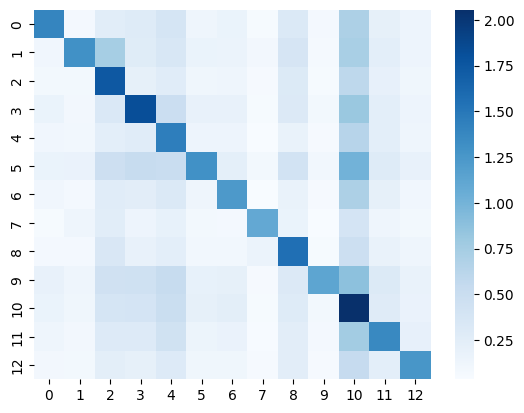

In [8]:
sns.heatmap(coeffA, cmap="Blues")

## Version with no production network

In [9]:
epsNtil = np.copy(epsN)
for i in range(epsNtil.shape[0]):
    epsNtil[i,:] = epsN[i,:]/np.sum(epsN[i,:])*np.sum(Omega[i,:])

In [10]:
curlyM = -curlyQ
I_o = np.eye(curlyT.shape[0])
I_j = np.eye(Psi.shape[0]) 
Xi_theta_till = curlyL @ I_j @ epsNtil @ (I_o - curlyM @ (I_o + curlyT))
coeffAtil = I_j @ (I_j + epsNtil @ (I_o - curlyM @ (I_o + curlyT)) @ np.linalg.inv((I_o - curlyM - Xi_theta_till)) @ (curlyL @ I_j - epsW_A))

<Axes: >

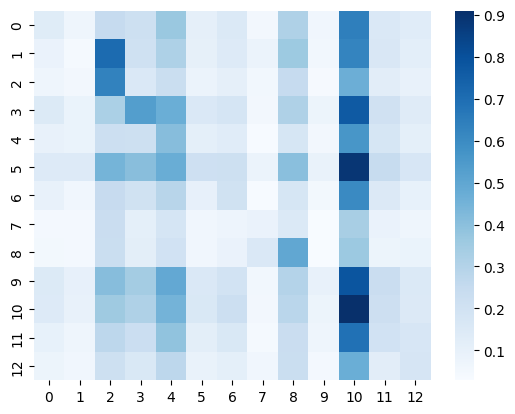

In [11]:
sns.heatmap(coeffA-coeffAtil, cmap="Blues")

In [12]:
coeffA-coeffAtil

matrix([[0.13250615, 0.06825181, 0.25014792, 0.21700417, 0.36835817,
         0.11059297, 0.15447529, 0.05522147, 0.31158948, 0.06292648,
         0.644781  , 0.15686946, 0.13087738],
        [0.08780708, 0.04536533, 0.70878592, 0.21031536, 0.31642697,
         0.10779611, 0.14425593, 0.08312167, 0.36092036, 0.05848107,
         0.62736395, 0.16466833, 0.11483636],
        [0.06748474, 0.05278677, 0.63283264, 0.15793415, 0.23170186,
         0.0814132 , 0.1094099 , 0.05866032, 0.250419  , 0.04155797,
         0.46621406, 0.12274771, 0.09551701],
        [0.1459316 , 0.08578959, 0.32242866, 0.53128633, 0.47069658,
         0.15615399, 0.18104077, 0.05605611, 0.31109732, 0.07697181,
         0.76598992, 0.20688071, 0.13736955],
        [0.09466122, 0.0864465 , 0.22360992, 0.217886  , 0.41037456,
         0.11226324, 0.12999884, 0.03495818, 0.17553526, 0.05315461,
         0.5624512 , 0.17578867, 0.11225593],
        [0.14379187, 0.14377049, 0.44628161, 0.40677271, 0.47602384,
         0.

In [94]:
def obj_reparam(control, param):
    epsNtil = param['epsNtil']
    coeffA = param['coeffA']
    curlyL = param['curlyL']
    epsW_A = param['epsW_A']
    dlog_A = param['dlog_A']
    sigma = param['sigma']
    agg = param['agg']
    I_o = np.eye(curlyL.shape[0])
    I_j = np.eye(curlyL.shape[1])
    
    curlyMtil = np.diag(control[:curlyL.shape[0]])
    curlyTtil = np.diag(control[curlyL.shape[0]:])

    Xi_theta_till = curlyL @ I_j @ epsNtil @ (I_o - curlyMtil @ (I_o + curlyTtil))
    coeffAtil = I_j @ (I_j + epsNtil @ (I_o - curlyMtil @ (I_o + curlyTtil)) @ np.linalg.inv((I_o - curlyMtil - Xi_theta_till)) @ (curlyL @ I_j - epsW_A))
    if agg:
        return np.linalg.norm( sigma.T @ (coeffAtil - coeffA) @ dlog_A)
    else:
        return np.max(np.abs((coeffAtil-coeffA) @ dlog_A))

    
    

In [117]:
dlog_A = np.zeros((J,1))
dlog_A[4] = 0.01
param = {'epsNtil':epsN, 'coeffA':coeffA, 'curlyL':curlyL, 'epsW_A':epsW_A, 'sigma':sigma, 'dlog_A':dlog_A, 'agg':False}
control0 = np.concatenate((np.diag(curlyM), np.diag(curlyT)))
optim_out = opt.minimize(fun=obj_reparam, x0=control0, args=(param), method='Nelder-Mead', tol=1e-12, options={'maxiter':1000000})

In [119]:
optim_out

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0032805508893719902
             x: [ 5.986e-01  7.086e-02 ...  5.422e-03  5.275e-03]
           nit: 26078
          nfev: 32709
 final_simplex: (array([[ 5.986e-01,  7.086e-02, ...,  5.422e-03,
                         5.275e-03],
                       [ 5.986e-01,  7.086e-02, ...,  5.422e-03,
                         5.275e-03],
                       ...,
                       [ 5.986e-01,  7.086e-02, ...,  5.422e-03,
                         5.275e-03],
                       [ 5.986e-01,  7.086e-02, ...,  5.422e-03,
                         5.275e-03]]), array([ 3.281e-03,  3.281e-03, ...,  3.281e-03,  3.281e-03]))

In [120]:
curlyMtil = np.diag(optim_out.x[:curlyL.shape[0]])
curlyTtil = np.diag(optim_out.x[curlyL.shape[0]:])
I_o = np.eye(curlyL.shape[0])
I_j = np.eye(curlyL.shape[1])
epsNtil = np.copy(epsN)
Xi_theta_till = curlyL @ I_j @ epsNtil @ (I_o - curlyMtil @ (I_o + curlyTtil))
coeffAtil = I_j @ (I_j + epsNtil @ (I_o - curlyMtil @ (I_o + curlyTtil)) @ np.linalg.inv((I_o - curlyMtil - Xi_theta_till)) @ (curlyL @ I_j - epsW_A))

In [121]:
(coeffA - coeffAtil)@dlog_A

matrix([[ 0.00187072],
        [ 0.00262677],
        [ 0.0017315 ],
        [ 0.00328055],
        [ 0.00291405],
        [ 0.00278117],
        [-0.00328055],
        [ 0.00144771],
        [ 0.00154559],
        [ 0.00165946],
        [ 0.00188153],
        [ 0.00268316],
        [ 0.0023456 ]])

In [24]:
def obj_reparam1(control, param):
    epsNtil = param['epsNtil']
    coeffA = param['coeffA']
    curlyL = param['curlyL']
    epsW_A = param['epsW_A']
    dlog_A = param['dlog_A']
    sigma = param['sigma']
    curlyMtil = param['curlyMtil']
    agg = param['agg']
    I_o = np.eye(curlyL.shape[0])
    I_j = np.eye(curlyL.shape[1])
    
    curlyTtil = np.diag(control)

    Xi_theta_till = curlyL @ I_j @ epsNtil @ (I_o - curlyMtil @ (I_o + curlyTtil))
    coeffAtil = I_j @ (I_j + epsNtil @ (I_o - curlyMtil @ (I_o + curlyTtil)) @ np.linalg.inv((I_o - curlyMtil - Xi_theta_till)) @ (curlyL @ I_j - epsW_A))
    if agg:
        return np.linalg.norm( sigma.T @ (coeffAtil - coeffA) @ dlog_A)
    else:
        return np.max(np.abs(100*(coeffAtil-coeffA) @ dlog_A))

In [25]:
dlog_A = np.zeros((J,1))
dlog_A[4] = 0.01
param = {'epsNtil':epsN, 'coeffA':coeffA, 'curlyL':curlyL, 'epsW_A':epsW_A, 'sigma':sigma, 'dlog_A':dlog_A, 'curlyMtil':curlyM, 'agg':False}
control0 = np.diag(curlyM)
optim_out = opt.minimize(fun=obj_reparam1, x0=control0, args=(param), method='Nelder-Mead', tol=1e-12, options={'maxiter':1000000})

In [26]:
optim_out

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.23122107155282423
             x: [-6.261e-01  1.533e+00 ... -5.801e-01  2.169e+00]
           nit: 9425
          nfev: 12908
 final_simplex: (array([[-6.261e-01,  1.533e+00, ..., -5.801e-01,
                         2.169e+00],
                       [-6.261e-01,  1.533e+00, ..., -5.801e-01,
                         2.169e+00],
                       ...,
                       [-6.261e-01,  1.533e+00, ..., -5.801e-01,
                         2.169e+00],
                       [-6.261e-01,  1.533e+00, ..., -5.801e-01,
                         2.169e+00]]), array([ 2.312e-01,  2.312e-01, ...,  2.312e-01,  2.312e-01]))

In [27]:
curlyTtil = np.diag(optim_out.x[:curlyL.shape[0]])
curlyMtil = np.copy(curlyM)
I_o = np.eye(curlyL.shape[0])
I_j = np.eye(curlyL.shape[1])
epsNtil = np.copy(epsN)
Xi_theta_till = curlyL @ I_j @ epsNtil @ (I_o - curlyMtil @ (I_o + curlyTtil))
coeffAtil = I_j @ (I_j + epsNtil @ (I_o - curlyMtil @ (I_o + curlyTtil)) @ np.linalg.inv((I_o - curlyMtil - Xi_theta_till)) @ (curlyL @ I_j - epsW_A))

In [30]:
100*(coeffA-coeffAtil)@dlog_A

matrix([[ 0.14771963],
        [-0.02610375],
        [ 0.03505407],
        [ 0.22367452],
        [-0.23122107],
        [-0.00085909],
        [-0.06353554],
        [ 0.00074379],
        [ 0.05427754],
        [-0.12158034],
        [-0.07609849],
        [ 0.00401993],
        [ 0.23122107]])

In [18]:
np.diag(curlyTtil)

array([-0.62611364,  1.53332035, -0.72808778, -4.89503723,  0.48830765,
        2.33534181,  0.40975345,  2.41497581,  3.74846989,  0.16094685,
        2.1970103 , -4.5444216 ,  4.93266615, -9.45769255,  3.80330058,
        1.37593895,  1.18381976, -0.60540612, -1.63616024,  2.56566199,
       -0.58012469,  2.16888059])

## Allowing the algorithm to pick epsN as well. 

In [104]:
def obj_reparam_flex(control, param):
    epsNtil = param['epsNtil']
    coeffA = param['coeffA']
    curlyL = param['curlyL']
    epsW_A = param['epsW_A']
    I_o = np.eye(curlyL.shape[0])
    I_j = np.eye(curlyL.shape[1])
    
    curlyMtil = np.diag(control[:curlyL.shape[0]])
    curlyTtil = np.diag(control[curlyL.shape[0]:2*curlyL.shape[0]])
    epsNtil = control[2*curlyL.shape[0]:].reshape(epsNtil.shape)

    Xi_theta_till = curlyL @ I_j @ epsNtil @ (I_o - curlyMtil @ (I_o + curlyTtil))
    coeffAtil = I_j @ (I_j + epsNtil @ (I_o - curlyMtil @ (I_o + curlyTtil)) @ np.linalg.inv((I_o - curlyMtil - Xi_theta_till)) @ (curlyL @ I_j - epsW_A))

    return np.linalg.norm(coeffAtil-coeffA)

    

In [120]:
param = {'epsNtil':epsN, 'coeffA':coeffA, 'curlyL':curlyL, 'epsW_A':epsW_A}
control0 = np.concatenate((np.diag(curlyM), np.diag(curlyT), np.array(epsN).flatten()))
optim_out = opt.minimize(obj_reparam_flex, control0, args=(param), method = 'Nelder-Mead', tol=1e-10, options={'maxiter':1000000})

In [122]:
curlyMtil = np.diag(optim_out.x[:curlyL.shape[0]])
curlyTtil = np.diag(optim_out.x[curlyL.shape[0]:2*curlyL.shape[0]])
epsNtil = optim_out.x[2*curlyL.shape[0]:].reshape(epsNtil.shape)
Xi_theta_till = curlyL @ I_j @ epsNtil @ (I_o - curlyMtil @ (I_o + curlyTtil))
coeffAtil = I_j @ (I_j + epsNtil @ (I_o - curlyMtil @ (I_o + curlyTtil)) @ np.linalg.inv((I_o - curlyMtil - Xi_theta_till)) @ (curlyL @ I_j - epsW_A))

In [124]:
coeffAtil - coeffA

matrix([[ 0.00331871,  0.03381115,  0.01393067,  0.09719583, -0.07136959,
          0.04686901, -0.03891742, -0.04834458, -0.17342767,  0.03145192,
         -0.06707796,  0.09724009, -0.0423344 ],
        [ 0.02914567, -0.00976531, -0.32492227,  0.12807846,  0.01285641,
          0.06353281, -0.00806543, -0.07729763, -0.1512437 ,  0.07690933,
          0.0094361 ,  0.12824657,  0.00158015],
        [-0.01322052, -0.01157598,  0.04499727,  0.00221208, -0.06423941,
          0.01064526, -0.0452694 , -0.0529687 ,  0.14174703,  0.01341606,
         -0.0586031 ,  0.00705449, -0.05610193],
        [-0.01953777,  0.06487845,  0.05487645, -0.16939346, -0.03472488,
          0.06846227, -0.02769945, -0.04604821, -0.11933098,  0.05673545,
          0.07337543,  0.0363244 , -0.03053698],
        [-0.04221127,  0.01062737,  0.03596493,  0.0184953 , -0.05985608,
          0.06448547, -0.03192891, -0.02880733, -0.04371283,  0.03377378,
         -0.00122824, -0.03269925, -0.04277804],
        [-0.042